# Sports Celebrity Image Classification Project 
# Lionel Messi, Maria Sharapova, Roger Federer, Serena Williams and Viral Kohli
# Key note: Celebrity eyes need to be clearly visible


## Dataset available at: https://github.com/codebasics/py/tree/master/DataScience/CelebrityFaceRecognition/images_dataset

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Import Libraries</span>

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Understanding single image (Exploratory Data Analysis)</span>

In [6]:
img = cv2.imread('./test_images/sharapova1.jpg')


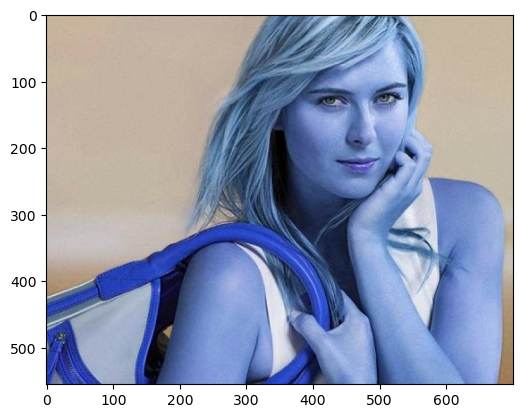

In [8]:
plt.imshow(img)


In [10]:
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

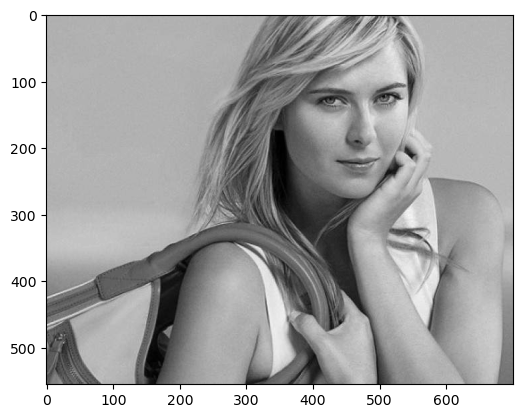

In [12]:
plt.imshow(gray, cmap='gray')

In [14]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [16]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]])

In [18]:
(x,y,w,h) = faces[0]
x,y,w,h

(352, 38, 233, 233)

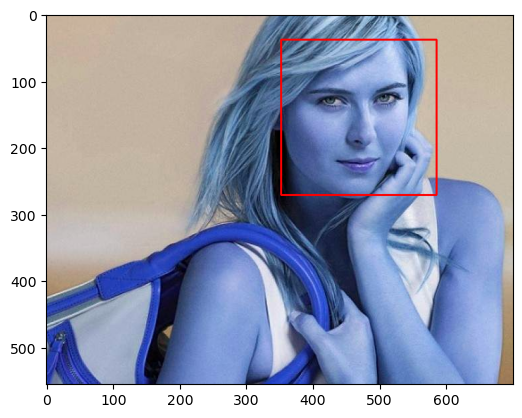

In [20]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

In [22]:
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Data Cleaning + Feature Engineering</span>

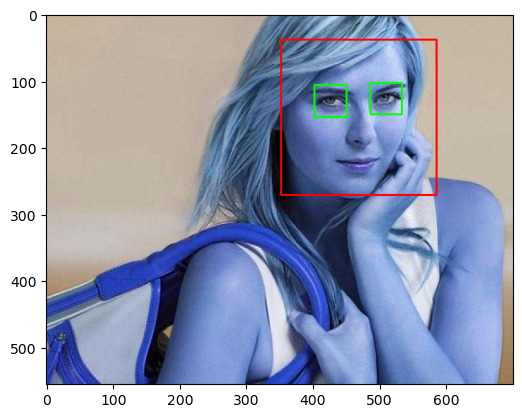

In [24]:
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

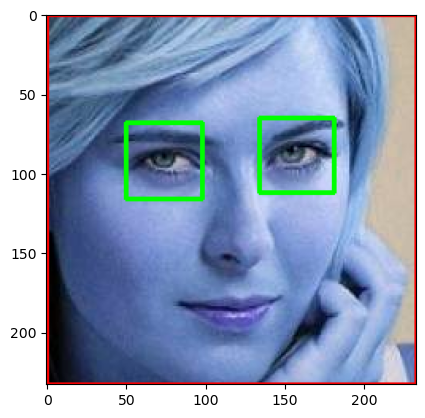

In [26]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

## Now that we understand how to get face and eyes, we will build a function to run through the images in the dataset

In [29]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None
    
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None
    return None

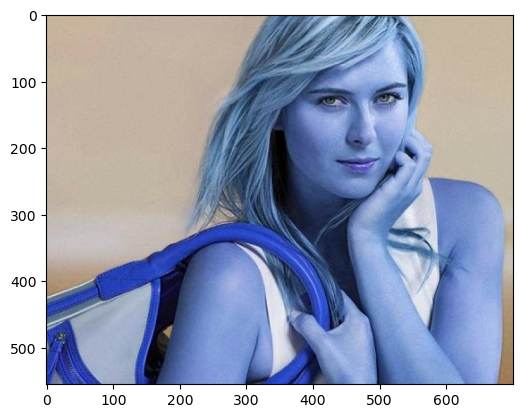

In [35]:
original_image = cv2.imread('./test_images/sharapova1.jpg')
plt.imshow(original_image)

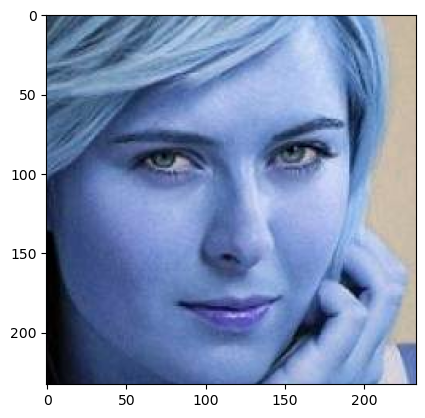

In [37]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')
plt.imshow(cropped_image)

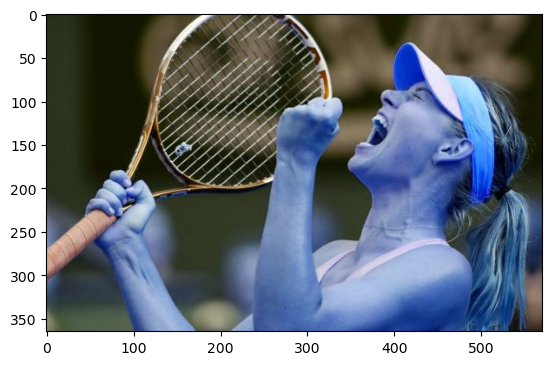

In [39]:
org_image_obstructed = cv2.imread('./test_images/sharapova2.jpg')
plt.imshow(org_image_obstructed)

In [41]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

## Above output is null since it cannot detect the yes of the subject

## Now, we run through all the images and create a folder for each celebrity under cropped folder

## Download data from the above link and store at images_dataset folder

In [ ]:
path_to_data = "./images_dataset/"
path_to_cr_data = "./images_dataset/cropped/"

import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1


## Once we have cropped images ready, We manually check the cropped images
## If something does not look right (example: wrong celebrity, too blurry), we can remove them at this stage
## This helps improve model accuracy

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Model Selection</span>

In [ ]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict


import os

X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        try:
            # Check if the file exists
            if not os.path.exists(training_image):
                print(f"File does not exist: {training_image}")
                continue

            # Read the image
            img = cv2.imread(training_image)
            
            # Check if the image was read successfully
            if img is None:
                print(f"Failed to read image: {training_image}")
                continue

            # Process the image
            scalled_raw_img = cv2.resize(img, (32, 32))
            img_har = w2d(img, 'db1', 5)
            scalled_img_har = cv2.resize(img_har, (32, 32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))
            
            X.append(combined_img)
            y.append(class_dict[celebrity_name])

        except Exception as e:
            print(f"Error processing {training_image}: {str(e)}")

print(f"Successfully processed {len(X)} images.")

len(X)

X[0]

X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

X[0]

X[1]

X

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

print(classification_report(y_test, pipe.predict(X_test)))



<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Hyperparameter Tuning</span>

In [42]:

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


{'cropped': 0,
 'lionel_messi': 1,
 'maria_sharapova': 2,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 5}

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Performance Metrics</span>

In [ ]:

best_estimators['svm'].score(X_test,y_test)

best_estimators['random_forest'].score(X_test,y_test)

best_estimators['logistic_regression'].score(X_test,y_test)

best_clf = best_estimators['svm']

best_clf

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')



<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Saving model + Other supporting files</span>

## These are need to build our streamlit image classification app

In [ ]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict